In [1]:
from glob import glob
import cv2
import numpy as np
import keras
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D, RepeatVector, Reshape, concatenate, Input,Activation
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications.inception_resnet_v2 import InceptionResNetV2


np.random.seed(42)

C:\Users\Banipreet\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#inception
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.get_default_graph()
    

In [3]:
def ColorModel(input_shape=(224,224,1)):
    
    embed_input = Input(shape=(1000,))
    
    #Encoder
    encoder_input = Input(input_shape)#H x W x 1
    encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)#H x W x 64
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)#H x W x 128
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)# H/2 X W/2 X 128
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)#H/2 X W/2 X 256
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)#H/4 X W/4 X 256
    encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)#H/8 X W/8 X 512
    encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)#H/8 X W/8 X 512
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)#H/8 X W/8 X 256
    #ENCODER_OUTPUT = (H/8,W/8,256)
    
    h = int(input_shape[0]/8)
    w = int(input_shape[1]/8)
    
    #Fusion
    fusion_output = RepeatVector(h*w)(embed_input)#replicate the inception embedding HW/64  times 
    fusion_output = Reshape(([h, w, 1000]))(fusion_output)#reshaping it into the conv of H/8 x W/8 x 1000
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) #H/8 x W/8 x 1256
    #embedding from inception network concatenated with the encoder. This ensures the embedding learnt from 1.2 million images in inception network are utilized for the network to get the correct prediction of the color of water or so
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)#1x1 kernel used 
    #FUSION_OUTPUT = (H/8,W/8,256)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)#H/8 X W/8 X 128
    decoder_output = UpSampling2D((2, 2))(decoder_output)#H/4 x W/4 x 128
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)#H/4 x W/4 x 64
    decoder_output = UpSampling2D((2, 2))(decoder_output)#H/2 x W/2 x 64
    decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)#H/2 x W/2 x 32
    decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)#H/2 x W/2 x 16
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)#H/2 x W/2 x 2
    decoder_output = UpSampling2D((2, 2))(decoder_output)#H x W x 2
    #So the a and b channels are obtained.

    model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

    return model

In [4]:
model = ColorModel((224,224,1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 112, 112, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 112, 112, 128 73856       conv2d_204[0][0]                 
__________________________________________________________________________________________________
conv2d_206 (Conv2D)             (None, 56, 56, 128)  147584      conv2d_205[0][0]                 
__________________________________________________________________________________________________
conv2d_207

In [5]:
import tarfile
from sklearn.model_selection import train_test_split
import keras_utils
from keras import backend as K
filename = "ImageNet_1G.tar.gz"


In [6]:
from skimage import color,io
def rgb2lab(img):
    return color.rgb2lab(img)

def lab2rgb(img):
    return color.lab2rgb(img)

def rgb2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gray2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr2lab(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

def resize(img, size):
    return cv2.resize(img,dsize=size)
    

In [7]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = bgr2rgb(img)
    return img

In [8]:
# reads bytes directly from tar by filename (slow, but ok for testing, takes ~6 sec)
def read_raw_from_tar(tar_fn, fn):
    with tarfile.open(tar_fn) as f:
        m = f.getmember(fn)
        return f.extractfile(m).read()

In [9]:
def embeddings(X_train):
    with inception.graph.as_default():
        embed = inception.predict(X_train)
    return embed
        

In [10]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

In [11]:
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

all_files = sorted(get_all_filenames(filename))  # list all files in tar sorted by name

In [12]:
# split into train/test
tr_files, te_files = train_test_split(all_files, test_size=0.1, random_state=42)

In [13]:
def raw_generator_from_tar(tar_fn, files):
    with tarfile.open(tar_fn) as f:
        while True:
            m = f.next()
            if m is None:
                break
            if m.name in files:
                obj = f.extractfile(m)
                if obj != None:yield f.extractfile(m).read()

In [14]:
# batch generator# batch  
BATCH_SIZE = 20

def batch_generator(items, batch_size):
    batch = [None] * batch_size
    for i, item in enumerate(items):
        batch[i%batch_size] = item
        if i%batch_size == batch_size-1:
            yield batch
            batch = [None] * batch_size
    if batch[0]:
        yield [item for item in batch if item]

In [15]:
def train_generator(files):
    while True:  # so that Keras can loop through this as long as it wants
        for batch in batch_generator(raw_generator_from_tar(filename, files), BATCH_SIZE):
            batch_img = []
            embed_img = []
            for raw in batch:
                image = decode_image_from_raw_bytes(raw)
                im = resize(image,(224,224))
                batch_img.append(rgb2lab(im))
                embed_img.append(resize(gray2rgb(rgb2gray(image)),(299,299)))
            batch_img = np.array(batch_img,dtype=float) #m x 224 x 224 x 3 in lab
            embed_img = np.array(embed_img,dtype=float) #m x 299 x 299 x 3 black and white
            
            X_batch = batch_img[:,:,:,0]
            X_batch = X_batch.reshape(X_batch.shape+(1,))
            X_batch = X_batch/100
        
            Y_batch = (batch_img[:,:,:,1:]) / 128
        
            embed_input = embed_img/255
        
        
            yield ([X_batch, embeddings(embed_input)], Y_batch)

In [16]:
# compile new model
model.compile(loss='mse',optimizer=keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

In [17]:
#train
model.fit_generator(train_generator(tr_files), 
                    epochs=50, 
                    steps_per_epoch=len(tr_files)//BATCH_SIZE,
                    callbacks = [keras_utils.TqdmProgressCallback()],
                   verbose=0)

Epoch 1/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 2/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 3/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 4/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 5/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 6/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 7/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 8/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 9/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 10/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 11/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 12/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 13/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 14/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 15/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 16/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 17/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 18/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 19/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 20/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 21/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 22/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 23/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 24/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 25/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 26/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 27/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 28/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 29/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 30/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 31/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 32/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 33/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 34/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 35/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 36/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 37/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 38/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 39/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 40/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 41/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 42/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 43/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 44/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 45/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 46/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 47/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 48/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 49/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))


Epoch 50/50


HBox(children=(IntProgress(value=0, max=353), HTML(value='')))

In [18]:
model.save_weights("weights.h5")

(1, 224, 224, 2)


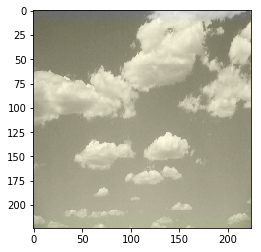

In [19]:
from glob import glob
test  =  np.array(glob('test/*'))
for img_path in test:
    img = cv2.imread(img_path)
    img = bgr2rgb(img)
    
    img_r = resize(img,(224,224))
    img_r = rgb2lab(img_r)
    
    x = img_r[:,:,0]
    x = x.reshape([1,224,224,1])
    x = x/100
    
    emb_in = resize(img,(299,299))
    emb_in = gray2rgb(rgb2gray(emb_in))
    emb_in = emb_in.reshape([1,299,299,3])
    emb_in = emb_in/255
    
    output = model.predict([x,embeddings(emb_in)])
    print(output.shape)
    
    curr = np.zeros((224,224,3),dtype='float')
    output = (output*128)
    output = output[0]
    
    
    curr[:,:,0] = img_r[:,:,0]
    curr[:,:,1] = output[:,:,0]
    curr[:,:,2] = output[:,:,1]
    #for i in range(256):
     #   for j in range(256):
      #      curr[i,j,0] = int(x[0,i,j,0])
       #     curr[i,j,1] = int(output[i,j,0])
        #    curr[i,j,2] = int(output[i,j,1])
    
    
    
    
    fi = lab2rgb(curr)
    #print(fi[:,:,0])
    
    plt.imshow(lab2rgb(curr))
    plt.show()
    '''
    
    
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    #imgC = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    #plt.imshow(imgC)
    #plt.show()Q
   # print(imgC.shape)
    img_r = cv2.resize(img,dsize=(256,256))
    print(img_r[:,:,2])
    temp = img_r[:,:,0]
    ans = model.predict([temp.reshape([1,256,256,1]),embeddings(img.reshape([1,img.shape[0],img.shape[1],3]))])
    curr = np.zeros((256,256,3))
    print(img_r.shape)
    plt.imshow(lab2rgb(img_r))
    plt.show()'''
    